In [1]:
from lxml import html
from functools import reduce
import requests
import re


def flatmap(f, l):
    m = map(f, l)
    return reduce(list.__add__, m)

def lmap(f, l):
    return list(map(f,l))
    

In [2]:
def split_scenes(script):
    """
    Split scenes in a script. Scene usually looks like: <b>EXT. Spaceship</b>
    """
    search = re.finditer("(?:<b>)?[ 0-9]*(INT|EXT)\.?", script)
    indexs = list(map(lambda m: m.start(), search))
    scenes = []
    
    start = indexs[0]
    for i in indexs[1:]:
        scenes.append(script[start:i])
        start = i
    scenes.append(script[start:])
    
    return scenes


In [3]:
def get_bold_dialogues(scene):
    """
    Extract dialogues from a scene. This works for scripts with dialogues in bold, like:
    
    <b> LUKE </b>
    I'm a Jedi like my father
    """
    reg = re.compile("<b>\s*([/A-Z0-9\- ]+?)\s*</b>(.+?)\n\n", re.S)
    search = reg.findall(scene[1:])
    return search

def get_colon_dialogues(scene):
    """
    Extract dialogues from a scene. This works for scripts with inlined dialogues, like:
    
    LUKE: I'm a Jedi like my father
    """
    reg = re.compile("\n?([/A-Z0-9\.\- ]+?)\s*:(.+?)(?=(?:\n\n|[\n\s]+([/A-Z0-9\. -]+?)\s*:)|$|</b>)", re.S)
    search = reg.findall(scene[1:])
    return search

def clean_dialogue(dialogue):
    """
    Clean dialogue. Steps:
    1. replace \n and \t for spaces
    2. merge more than one space
    3. remove stage directions between parenthesis
    """
    text = re.sub("[\n\t]+", " ", dialogue[1])
    text = re.sub("[ ]+", " ", text) 
    text = re.sub("\([a-z0-9A-Z,';\-\.\!\? ]+\)", "", text)
    return (dialogue[0].strip(), text.strip())

def suspicious_dialogues(dialogues):
    """
    Find suspicious dialogues, with names containing strange characters, 
    empty phrases or remaining stage directions
    """
    suspicious = []
    
    for (p,t) in dialogues:
        if re.search("[^A-Z0-9\-\. ]", p) is not None:
            suspicious.append((p,t))
        if re.search("[\(\)]", t) is not None:
            suspicious.append((p,t))
        if t == '' or p == '':
            suspicious.append((p,t))
    
    return suspicious 

In [4]:
pages = [
    ('http://www.imsdb.com/scripts/Star-Wars-The-Phantom-Menace.html',
     '//td[@class="scrtext"]/pre',
     lambda t: t.replace("<pre>", "", 1).replace("</pre>", "", 1).replace("9You", "(You"),
     get_colon_dialogues,
     lambda s: s
    ),
    ('http://www.imsdb.com/scripts/Star-Wars-Attack-of-the-Clones.html',
     '//td[@class="scrtext"]/pre',
     lambda t: t.replace("<pre>", "", 1).replace("</pre>", "", 1).replace("(continuing\n", "(continuing)\n"),
     get_bold_dialogues,
     lambda s: s
    ),
     ('http://www.imsdb.com/scripts/Star-Wars-Revenge-of-the-Sith.html',
     '//td[@class="scrtext"]',
     lambda t: t.replace("<td>", "", 1).replace("</td>", "", 1).replace("<br>", "\n"),
     get_colon_dialogues,
     lambda s: s[:-1]
    ),
     ('http://www.imsdb.com/scripts/Star-Wars-A-New-Hope.html',
     '//td[@class="scrtext"]/pre',
     lambda t: t.replace("<pre>", "", 1).replace("</pre>", "", 1),
     get_bold_dialogues,
     lambda s: s
    ),
     ('http://www.imsdb.com/scripts/Star-Wars-The-Empire-Strikes-Back.html',
     '//td[@class="scrtext"]/pre',
     lambda t: t.replace("<pre>", "", 1).replace("</pre>", "", 1),
     get_bold_dialogues,
     lambda s: s[:-1]
    ),
     ('http://www.imsdb.com/scripts/Star-Wars-Return-of-the-Jedi.html',
     '//td[@class="scrtext"]/pre',
     lambda t: t.replace("<pre>", "", 1).replace("</pre>", "", 1),
     get_bold_dialogues,
     lambda s: s
    ),
]


def process_pages(pages):
    """
    Returns dataset with all the phrases
    """
    #return list(map(lambda p: process_page(*p), pages))
    return flatmap(lambda p: process_page(*p), pages)

def process_page(link, xpath, process, get_dialogues, scene_selector):
    """
    Process one page
    """    
    print("PROCESSING:", link)
    
    tree = html.fromstring(requests.get(link).content)
    
    script = html.tostring(tree.xpath(xpath)[0]) \
            .decode()
    script = process(script)
    
    scenes = scene_selector(split_scenes(script))
     
    dialogues = flatmap(get_dialogues, scenes)
    dialogues = lmap(clean_dialogue, dialogues)

    sd = suspicious_dialogues(dialogues)
    
    dialogues = list(set(dialogues) - set(sd))
    
    if len(sd) > 0:
        print("SUSPICIOUS DIALOGUES:", link)
        
        for d in sd:
            print(d)
            
        print("=====================")
    
    return dialogues

data = process_pages(pages)

PROCESSING: http://www.imsdb.com/scripts/Star-Wars-The-Phantom-Menace.html
SUSPICIOUS DIALOGUES: http://www.imsdb.com/scripts/Star-Wars-The-Phantom-Menace.html
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
('FODE/BEED', '-')
PROCESSING: http://www.imsdb.com/scripts/Star-Wars-Attack-of-the-Clones.html
PROCESSING: http://www.imsdb.com/scripts/Star-Wars-Revenge-of-the-Sith.html
SUSPICIOUS DIALOGUES: http://www.imsdb.com/scripts/Star-Wars-Revenge-of-the-Sith.html
('ANAKIN/OBI-WAN', 'Well, that was close.')
PROCESSING: http://www.imsdb.com/scripts/Star-Wars-A-New-Hope.html
PROCESSING: http://www.imsdb.com/scripts/Star-Wars-The-Empire-Strikes-Back.html
PROCESSING: http://www.imsdb.com/scripts/Star-Wars-Return-of-the-Jedi.html


In [5]:
# unify names and correct mistakes

aliases = {
    "ANAKN": "ANAKIN",
    "ANKAIN": "ANAKIN",
    "ANAKINN": "ANAKIN",
    "ANAKNI": "ANAKIN",
    "BEN": "OBI-WAN",
    "DOFINE": "CAPTAIN DOFINE",
    "PALPATINE": "DARTH SIDIOUS",
    "QU-IG0N": "QUI-GON",
    "PANAKA": "CAPTAIN PANAKA",
    "A": "FODE/BEED",
    "B": "FODE/BEED",
    ". PADME": "PADME",
    "ARTOO. QUI-GON": "QUI-GON",
    "PALAPATINE": "DARTH SIDIOUS",
    "AMIDALA": "PADME",
    "KI-ADI": "KI-ADI-MUNDI",
    "CAPT. PANAKA": "CAPTAIN PANAKA", 
    "MACE WINDU": "MACE-WINDU",
    "MACE": "MACE-WINDU",
    "DABTH SIDIOUS": "DARTH SIDIOUS",
    "DOOKU": "COUNT DOOKU",
    "QUI -GON": "QUI-GON",
    "THREEPIO": "C-3PO",
    "G-3PO": "C-3PO",
    "BOUSHH": "LEIA",
    "VADER": "DARTH VADER",
    "TC14": "TC-14",
    "PR-4": "PK-4",
    "MAD AMEDDA": "MAS AMEDDA",
    "FANTA. JAR JAR": "JAR JAR",
    "JOVAL": "JOBAL",
    "OBI-WAM": "OBI-WAN",
    "PAMDE": "PADME",
    "ELAN": "ELAN SLEAZEBAGGANO",
    "BOBA": "BOBA FETT",
    "ZAM": "ZAM WESSEL",
    "BAIL": "BAIL ORGANA",
    "QUI -GON": "QUI-GON",
    "HAN": "HAN SOLO",
    "JANGO": "JANGO FETT",
    "NDU": "MACE-WINDU",
    "-ADI-MUNDI": "KI-ADI-MUNDI",
    "DDEAN DANU": "GIDDEAN DANU",
    "ON MEDON": "TION MEDON",
    "FANGZAR": "FANG ZAR",
    "BERU": "AUNT BERU",
    "LURE": "LUKE",
    "EMPEROR": "DARTH SIDIOUS",
    "DIOUS": "DARTH SIDIOUS",
    "NUTE": "NUTE GUNRAY",
    #ERRORS IN PARSING
    "19   HOLDING TUNNEL - RANCOR PIT": "",
    "PAGE 83": "",
    "AREA": "",
    "SPACE": "",
    "SPEEDER LOT": "",
    "DAY": ""
}


data = lmap(lambda d: (aliases[d[0]], d[1]) if d[0] in aliases else d, data)
data = list(filter(lambda d: d[0] != '', data))

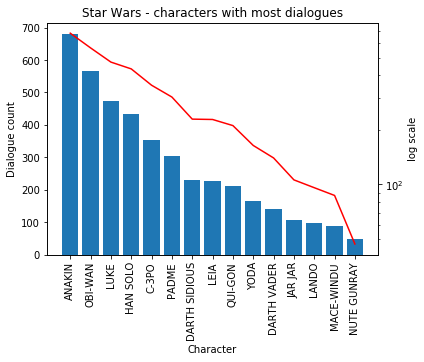

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def count_occurances(data):
    occ = {}
    
    for person, phrase in data:
        if person in occ:
            occ[person] += 1
        else:
            occ[person] = 1
    return occ
            
occurances = count_occurances(data)
occ = sorted(occurances.items(), key=lambda x:x[1], reverse=True)[:15]

labels = lmap(lambda x:x[0], occ)
values = lmap(lambda x:x[1], occ)

y_pos = np.arange(len(labels))

fig, ax1 = plt.subplots()

ax1.bar(y_pos, values)
ax1.set_xlabel('Character')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Dialogue count')

ax2 = ax1.twinx()
ax2.plot(y_pos, values, c="r")
ax2.set_ylabel('log scale')
ax2.set_yscale("log")

fig.tight_layout()


ax1.set_xticks(y_pos)
ax1.set_xticklabels(labels, rotation=90)
plt.title('Star Wars - characters with most dialogues')
 
plt.show()

Word count: 27735 Vocabulary: 4452


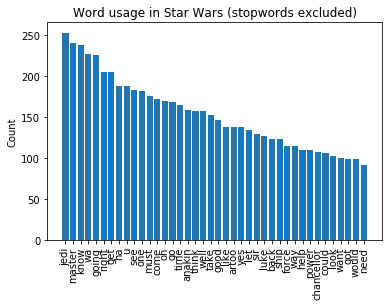

In [7]:
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from math import floor
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

tknzr = TweetTokenizer()
wnlzr = WordNetLemmatizer()

text_data = lmap(lambda x:x[1], data)
text_data = lmap(lambda x: re.sub('[^a-z0-9]', ' ', x.lower()), text_data)
text_data = lmap(lambda x: tknzr.tokenize(x), filter(lambda x: re.search('[0-9a-z]', x), text_data))
text_data = flatmap(lambda phrase: lmap(wnlzr.lemmatize, phrase), text_data)
text_data

word_occ = {}

for w in text_data:
    if w in word_occ:
        word_occ[w] += 1
    else:
        if w not in stop:
            word_occ[w] = 1
        
vocab = len(word_occ)
word_len = sum(word_occ.values())

print("Word count:", word_len, "Vocabulary:", vocab)
        
word_occ = sorted(word_occ.items(), key=lambda x:x[1], reverse=True)[:40]

wo_labels = lmap(lambda x:x[0], word_occ)
wo_values = lmap(lambda x:x[1], word_occ)

y_pos = np.arange(len(wo_labels))
 
plt.bar(y_pos, wo_values, align='center')
plt.xticks(y_pos, wo_labels, rotation=90)
plt.ylabel('Count')
plt.title('Word usage in Star Wars (stopwords excluded)')
 
plt.show()


In [8]:
excluded_names = [x[0] for x in occurances.items() if x[1] < 5]

print(excluded_names)

data = list(filter(lambda d: d[0] not in excluded_names, data))

['GUI-GON', 'RABE', 'CONTROL ROOM COMMANDER', 'CLONE CAPTAIN', 'JEDI CHILD MAY', 'MOTEE', 'HUMAN', 'GUNGAN LOOKOUT', 'SUPER BATTLE DROID R77', 'BRAVO TWO', 'AMBASSADOR DARSANA', 'OOM-9', 'FIXER', 'ARTOO BEEPS', 'IMPERIAL OFFICER', 'TERR TANEEL', 'SENATOR ASK AAK', 'FOOD SERVER', 'ASSEMBLY', 'GUARD DROID', 'FODE BEED', 'VOICE', 'JEDI CHILD JACK', 'REBEL OFFICER', 'SENIOR CONTROLLER', 'EG-9', 'FANTA', 'GANTRY OFFICER', 'BARTENDER', 'ZAM WESSEL', 'CLONE PILOT 2', 'LOTT DOD', 'DROID 1', 'FIGHTER PILOT', 'WALD', 'REBEL FIGHTER', 'ROYAL GUARD', 'WILLARD', 'SECOND TROOPER', 'AAYLA', 'SCOUT', 'HEAD CONTROLLER', 'BANA BREEMU', 'OFFICER CASS', 'DROID GUARD', 'DAR WAC', 'OWO-1', 'CLONE COMMANDER THIRE', 'ELAN SLEAZEBAGGANO', 'BATTLE DROID CAPTAIN', 'ORN FREE TAA', 'FIRST OFFICER', 'HOBBIE', 'SECOND THREEPIO', 'CLONE PILOT', 'PILOTS', 'BLY', 'WINGMAN', 'BATTLE DROID', 'YOUNGLINGS', 'CHILDREN', 'TECHNICIAN', 'ASSISTANT OFFICER', 'CLONE TROOPER', 'HERMIONE', 'SUPER BATTLE DROID', 'ANNOUNCER', 'OPERA

In [9]:
names = sorted(list(set(map(lambda d: d[0], data))))
    
for i,n in enumerate(names):
    print(i, n)

name_dict = {}

for i,n in enumerate(names):
    name_dict[n] = i
    
def get_target(name):
    return name_dict[name]

def get_name(target):
    for k,v in name_dict.items():
        if v == target:
            return k

0 ACKBAR
1 ANAKIN
2 AUNT BERU
3 BAIL ORGANA
4 BIB
5 BIBBLE
6 BIGGS
7 BOBA FETT
8 BOSS NASS
9 C-3PO
10 CAPTAIN
11 CAPTAIN PANAKA
12 CAPTAIN TYPHO
13 CLIEGG
14 CLONE COMMANDER CODY
15 CLONE SERGEANT
16 COMMANDER
17 CONTROLLER
18 COUNT DOOKU
19 CREATURE
20 DARTH MAUL
21 DARTH SIDIOUS
22 DARTH VADER
23 DECK OFFICER
24 DODONNA
25 FIRST TROOPER
26 FODE/BEED
27 GENERAL GRIEVOUS
28 GOLD FIVE
29 GOLD LEADER
30 GREEDO
31 GUARD
32 HAN SOLO
33 JABBA
34 JANGO FETT
35 JAR JAR
36 JERJERROD
37 JIRA
38 JOBAL
39 JOCASTA NU
40 KI-ADI-MUNDI
41 KITSTER
42 LAMA SU
43 LANDO
44 LEIA
45 LUKE
46 MACE-WINDU
47 MAS AMEDDA
48 MEDICAL DROID
49 MON MOTHMA
50 NEEDA
51 NINEDENINE
52 NUTE GUNRAY
53 OBI-WAN
54 OFFICER
55 OWEN
56 OZZEL
57 PADME
58 PIETT
59 PILOT
60 PK-4
61 QUEEN JAMILLIA
62 QUI-GON
63 RED LEADER
64 RED TEN
65 RIC OLIE
66 RIEEKAN
67 RUNE
68 RUWEE
69 SEBULBA
70 SHMI
71 SIO BIBBLE
72 SOLA
73 STORMTROOPER
74 TARKIN
75 TAUN WE
76 TION MEDON
77 TROOPER
78 VALORUM
79 VEERS
80 WATTO
81 WEDGE
82 YODA
83 ZEV


In [11]:
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import PorterStemmer

tknzr = TweetTokenizer()
porter_stemmer = PorterStemmer()

def process_text(text):
    txt = re.sub('[^a-z0-9]', ' ', text.lower())
    tokens = [porter_stemmer.stem(t) for t in tknzr.tokenize(txt) if re.search('[a-zA-Z0-9]', t)]
    return " ".join(tokens)


train_data = []
train_targets = []

for d in data:
    train_data.append(process_text(d[1]))
    train_targets.append(get_target(d[0]))
    
from sklearn.model_selection import train_test_split

train_data, X_test, train_targets, Y_test = train_test_split(train_data, train_targets, test_size=0.1)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier


text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3,
                                            max_iter=5, tol=None)),
])

from sklearn.model_selection import GridSearchCV

parameters = {'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
              'tfidf__use_idf': (True, False),
             'clf__alpha': (1e-2, 1e-3, 1e-4),
              'clf__max_iter': (5, 10, 15)
}

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=10)

gs_clf.fit(train_data, train_targets)  

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True 
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True 
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=True 
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True, score=0.25274725274725274, total=   0.3s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True, score=0.2457293035479632, total=   0.3s
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True, score=0.25821596244131456, total=   0.3s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=True 
[CV] clf__alpha=0.01, vect__ngram_range

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s


[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=True, score=0.2663219133807369, total=   1.1s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=True, score=0.26938239159001315, total=   1.3s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=True, score=0.2749832327297116, total=   1.3s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True, score=0.26438267614738203, total=   1.5s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False 


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.3s


[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False, score=0.23270846800258566, total=   0.3s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True, score=0.26544021024967146, total=   1.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False, score=0.23390275952693823, total=   0.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False, score=0.2515090543259557, total=   0.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True, score=0.28303152246814217, total=   1.6s
[CV] clf__

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.8s


[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=False, score=0.2605042016806723, total=   1.0s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=False, score=0.25821287779237845, total=   1.1s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=False, score=0.2790073775989269, total=   1.2s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False, score=0.2572721396250808, total=   1.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.4s


[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False, score=0.2621550591327201, total=   1.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False, score=0.266934942991281, total=   1.6s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=True, score=0.2682611506140918, total=   0.9s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=True, score=0.266754270696452, total=   0.9s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=True, score=0.2776659959758551, total=   0.9s
[CV] clf__alph

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.5s


[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False, score=0.24369747899159663, total=   0.5s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=True, score=0.27213962508080153, total=   2.1s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False, score=0.2371879106438896, total=   0.7s
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False, score=0.24882629107981222, total=   0.5s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=False 
[CV] clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=True, score=0.26609724047306177, total=   2.0s
[

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s


[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=False, score=0.27537168713639304, total=   1.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=False, score=0.26412614980289095, total=   1.6s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=False, score=0.26961770623742454, total=   1.8s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=False, score=0.2734324499030381, total=   2.1s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=15, tfidf__use_idf=True, score=0.2482223658694247, total=   0.7s
[CV

[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.5s


[CV]  clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True, score=0.2776659959758551, total=   1.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True, score=0.26955397543632836, total=   2.3s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True, score=0.26872536136662284, total=   1.9s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True, score=0.28169014084507044, total=   2.2s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 1), clf__max_iter=15, tfidf__use_idf=False, score=0.24111182934712347, total=   0.7s
[CV] c

[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   24.1s


[CV]  clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=False, score=0.25821287779237845, total=   1.4s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=False, score=0.28034875922199864, total=   1.1s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=False, score=0.27020038784744665, total=   2.0s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=False, score=0.2680683311432326, total=   2.1s
[CV] clf__alpha=0.01, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.01, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=False, score=0.28504359490274983, total=   1.9s

[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   30.3s


[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=True, score=0.2682611506140918, total=   1.2s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=True, score=0.26609724047306177, total=   1.1s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=True, score=0.2790073775989269, total=   1.2s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False, score=0.23529411764705882, total=   0.4s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True, score=0.26244343891402716, total=   1.7s
[CV] c

[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   34.3s


[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=False, score=0.27084680025856495, total=   1.3s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=False, score=0.2588699080157687, total=   1.1s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=False, score=0.26961770623742454, total=   1.1s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=False, score=0.2585649644473174, total=   1.6s
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=True, score=0.2546864899806076, total=   0.6s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=True 
[

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   40.6s


[CV]  clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=True, score=0.2689075630252101, total=   2.0s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False, score=0.2501616031027796, total=   0.5s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False, score=0.22930354796320632, total=   0.5s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False, score=0.23809523809523808, total=   0.6s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 2), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=True, score=0.266754270696452, total=   

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   47.2s


[CV]  clf__alpha=0.001, vect__ngram_range=(1, 1), clf__max_iter=15, tfidf__use_idf=True, score=0.2562038900067069, total=   0.8s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=False, score=0.27230046948356806, total=   2.2s
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=False, score=0.2621550591327201, total=   2.4s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True 
[CV] clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True, score=0.2656755009696186, total=   1.5s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True, score=0.28169014084507044, total=   1.2s

[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   54.8s


[CV] clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=False, score=0.26544021024967146, total=   1.9s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=False, score=0.27149321266968324, total=   2.0s
[CV] clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=False 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=False, score=0.2790073775989269, total=   2.3s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.001, vect__ngram_range=(1, 4), clf__max_iter=15, tfidf__use_idf=False, score=0.2727860374919198, total=   2.5s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=True 
[CV]  clf__alpha=0.0001, vect__ngra

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min


[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False, score=0.2371879106438896, total=   0.6s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 1), clf__max_iter=5, tfidf__use_idf=False, score=0.22937625754527163, total=   0.6s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True, score=0.25821287779237845, total=   1.5s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 4), clf__max_iter=5, tfidf__use_idf=True, score=0.2608987256874581, total=   1.5s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 3), clf__max_iter=5, tfidf__use_idf=False 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=5, tfidf__use_idf=False, score=0.2614980289093298, total=  

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.1min


[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=True, score=0.2592113768584357, total=   1.4s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=True, score=0.2536136662286465, total=   1.4s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=True 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 3), clf__max_iter=10, tfidf__use_idf=True, score=0.27297116029510393, total=   1.5s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=True, score=0.2553329023917259, total=   1.9s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 1), clf__max_iter=10, tfidf__use_idf=False, score=0.24692954104718812, tot

[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min


[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=False, score=0.259526938239159, total=   1.9s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 4), clf__max_iter=10, tfidf__use_idf=False, score=0.27230046948356806, total=   1.9s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True, score=0.2605042016806723, total=   1.0s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True, score=0.25624178712220763, total=   1.1s
[CV] clf__alpha=0.0001, vect__ngram_range=(1, 3), clf__max_iter=15, tfidf__use_idf=True 
[CV]  clf__alpha=0.0001, vect__ngram_range=(1, 2), clf__max_iter=15, tfidf__use_idf=True, score=0.26626425217974514, tota

[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:  1.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__alpha': (0.01, 0.001, 0.0001), 'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)], 'tfidf__use_idf': (True, False), 'clf__max_iter': (5, 10, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [18]:
print(gs_clf.best_params_)

def predict(text):
    new_text = process_text(text)
    return get_name(gs_clf.predict([new_text]))

predicted = gs_clf .predict(train_data)

correct = len(list(filter(lambda p: p[0] == p[1], zip(train_targets, predicted))))

test = gs.clf.predict(X)

{'clf__max_iter': 10, 'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [14]:
print(correct / len(train_data))

0.9508584961515689


In [32]:
predict("I'm a jedi like my father")

'LUKE'

In [16]:
from sklearn import metrics

target_names = lmap(get_name, list(set(train_targets)))

print(metrics.classification_report(train_targets, predicted,
    target_names=target_names))

                      precision    recall  f1-score   support

              ACKBAR       1.00      1.00      1.00        11
              ANAKIN       0.92      0.95      0.93       681
           AUNT BERU       1.00      0.75      0.86         8
         BAIL ORGANA       0.90      1.00      0.95        46
                 BIB       1.00      0.80      0.89         5
              BIBBLE       1.00      1.00      1.00        10
               BIGGS       0.67      0.97      0.80        34
           BOBA FETT       0.91      0.91      0.91        11
           BOSS NASS       1.00      0.94      0.97        17
               C-3PO       0.92      0.97      0.95       352
             CAPTAIN       1.00      0.67      0.80         6
      CAPTAIN PANAKA       1.00      0.92      0.96        39
       CAPTAIN TYPHO       1.00      1.00      1.00        10
              CLIEGG       1.00      1.00      1.00         5
CLONE COMMANDER CODY       0.47      0.90      0.62        10
      C

In [28]:
import pickle

with open('star-wars.pickle', 'wb') as model_file:
    pickle.dump(gs_clf, model_file)
